In [32]:
import sys
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import lightning.pytorch as pl
from utils.DataLoader import load_data
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import plotly.express as px
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pickle
from ssa.btgym_ssa import SSA
import math

In [33]:
tank_sample_id = 'A205_1'
batch_size = 128
max_prediction_length = 2*24 #the goal is to make a one-day forecast 48
max_encoder_length = 3*2*24
training_cutoff = 2000 - max_prediction_length
test_sequence = pd.read_csv('tankleak.csv')
test_sequence = test_sequence[(test_sequence['group_id'] == tank_sample_id)]
test_sequence = test_sequence.drop(columns=["Month", "Year", "Season"])
test_sequence['period'] = test_sequence['period'].astype(str)

In [72]:
test_sequence=test_sequence[test_sequence['period']=='0']
X = np.array(test_sequence['Var_tc_readjusted'].iloc[:training_cutoff].values)
ssa = SSA(window=5, max_length=len(X))
X_pred = ssa.reset(X)
X_pred = ssa.transform(X_pred, state=ssa.get_state())
reconstructeds = X_pred.sum(axis=0)
residuals = X - reconstructeds
resmean = residuals.mean()
M2 = ((residuals - resmean) ** 2).sum()

In [35]:
path = 'C:/Users/Administrator/Documents/GitHub/tft/pytorch_forecasting/CPD/tl_test/trial_0/epoch=25.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)

C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [69]:
quantile = 0.95
threshold = 1 
train = test_sequence.iloc[:training_cutoff]
train['Var_tc_readjusted'] = X
test_data = TimeSeriesDataSet(
    test_sequence[lambda x: (x.time_idx < training_cutoff)],
    time_idx="time_idx",
    target="Var_tc_readjusted",  # variance
    group_ids=["group_id"],  # tank id
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group_id"],  # tank id, tank location state
    static_reals=["tank_max_height", "tank_max_volume"],
    # tank max height, tank max volume, no. of pumps attached to the tank
    time_varying_known_categoricals=["Time_of_day"],  # season, month, "Month", "Year", "Season"
    time_varying_known_reals=["time_idx"],  # time_idx,
    time_varying_unknown_categoricals=["period"],  # period (idle, transaction, delivery)
    time_varying_unknown_reals=[
        "Var_tc_readjusted",
        "Del_tc",
        "Sales_Ini_tc",
        "ClosingHeight_tc_readjusted",
        "ClosingStock_tc_readjusted",
        "TankTemp",
    ],  # variance, volume, height, sales(-), delivery(+), temperature,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
tn = TimeSeriesDataSet.from_dataset(test_data,  train, stop_randomization=True)
train_dataloader = tn.to_dataloader(train=False, batch_size=128, num_workers=0)
train_predictions = best_tft.predict(train_dataloader, mode="raw", return_x=True,trainer_kwargs=dict(accelerator="cpu"))
trainpred = train_predictions.output["prediction"][:,:,3]
traintarget = train_predictions.x["decoder_target"][:,:]
MSE = torch.mean((trainpred - traintarget)**2, dim=1)
mse_quantile = np.quantile(MSE, quantile)
final_threshold = threshold * mse_quantile

C:\Users\Administrator\AppData\Local\Temp\ipykernel_35536\2939184021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Var_tc_readjusted'] = X
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler wa

In [82]:
test_seq = test_sequence.iloc[training_cutoff:]
test_seq = test_seq.reset_index(drop=True)
test_seq['time_idx'] = test_seq.index
ctr = 0
scores = [0]*test_seq.shape[0]
errors = np.array(MSE)
thresholds = [final_threshold]*test_seq.shape[0]
step = max_prediction_length
out_threshold = 1.5
outliers = []
filtered = []
while ctr < test_seq.shape[0]:
    new = test_seq['Var_tc_readjusted'].iloc[ctr:ctr + step].values
    updates = ssa.update(new)
    updates = ssa.transform(updates, state=ssa.get_state())[:, 5-1:]
    reconstructed = updates.sum(axis=0)
    residual = new - reconstructed
    residuals = np.concatenate([residuals, residual])
    # start_time = time.time()
    for i1 in range(len(new)):
        delta = residual[i1] - resmean
        resmean += delta / (ctr + i1 + training_cutoff)
        M2 += delta * (residual[i1] - resmean)
        stdev = math.sqrt(M2 / (ctr + i1 + training_cutoff - 1))
        threshold_upper = resmean + out_threshold * stdev
        threshold_lower = resmean - out_threshold * stdev

        if residual[i1] > threshold_upper or residual[i1] < threshold_lower:
            outliers.append(ctr + i1)
            filtered.append(np.mean(filtered[-5:] if len(filtered) > 5 else 0))
        else:
            filtered.append(new[i1])
    test_seq.loc[ctr:ctr + step-1, 'Var_tc_readjusted'] = filtered[-step:]
    
    if ctr >= max_prediction_length + max_encoder_length:           
        new_prediction_data = test_seq[ctr + step - max_prediction_length - max_encoder_length:ctr + step]
        new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
        onepred = new_raw_predictions.output["prediction"][:,:,3]
        onetarget = new_raw_predictions.x["decoder_target"][:,:]
        mse_values = torch.mean((onepred - onetarget)**2, dim=1)
        errors = np.append(errors, mse_values) 
        mse_quantile = np.quantile(errors, quantile)
        final_threshold = threshold * mse_quantile
        thresholds[ctr:ctr + step] = [final_threshold]*step
        scores[ctr:ctr + step] = [mse_values]*step
    
    ctr += step
    if ctr + step >= test_seq.shape[0]:
        break

C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py

In [74]:
tlgrouths = pd.read_csv('C:/Users/Administrator/Documents/GitHub/tft/data_simulation/tl/tankleakage_info.csv', index_col=0).reset_index(drop=True)
site_id = tank_sample_id[:4]
tank_id = tank_sample_id[-1]
tank_info = tlgrouths[(tlgrouths['Site']==site_id) & (tlgrouths['Tank']==int(tank_id))]
startdate = tank_info.iloc[0]['Start_date']
stopdate = tank_info.iloc[0]['Stop_date']
temp_df = test_seq[test_seq['Time_DN'] > startdate]
startindex = temp_df.iloc[0]['time_idx']
temp_df = test_seq[test_seq['Time_DN'] > stopdate]
stopindex = temp_df.iloc[0]['time_idx']

C:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


<Figure size 640x480 with 0 Axes>

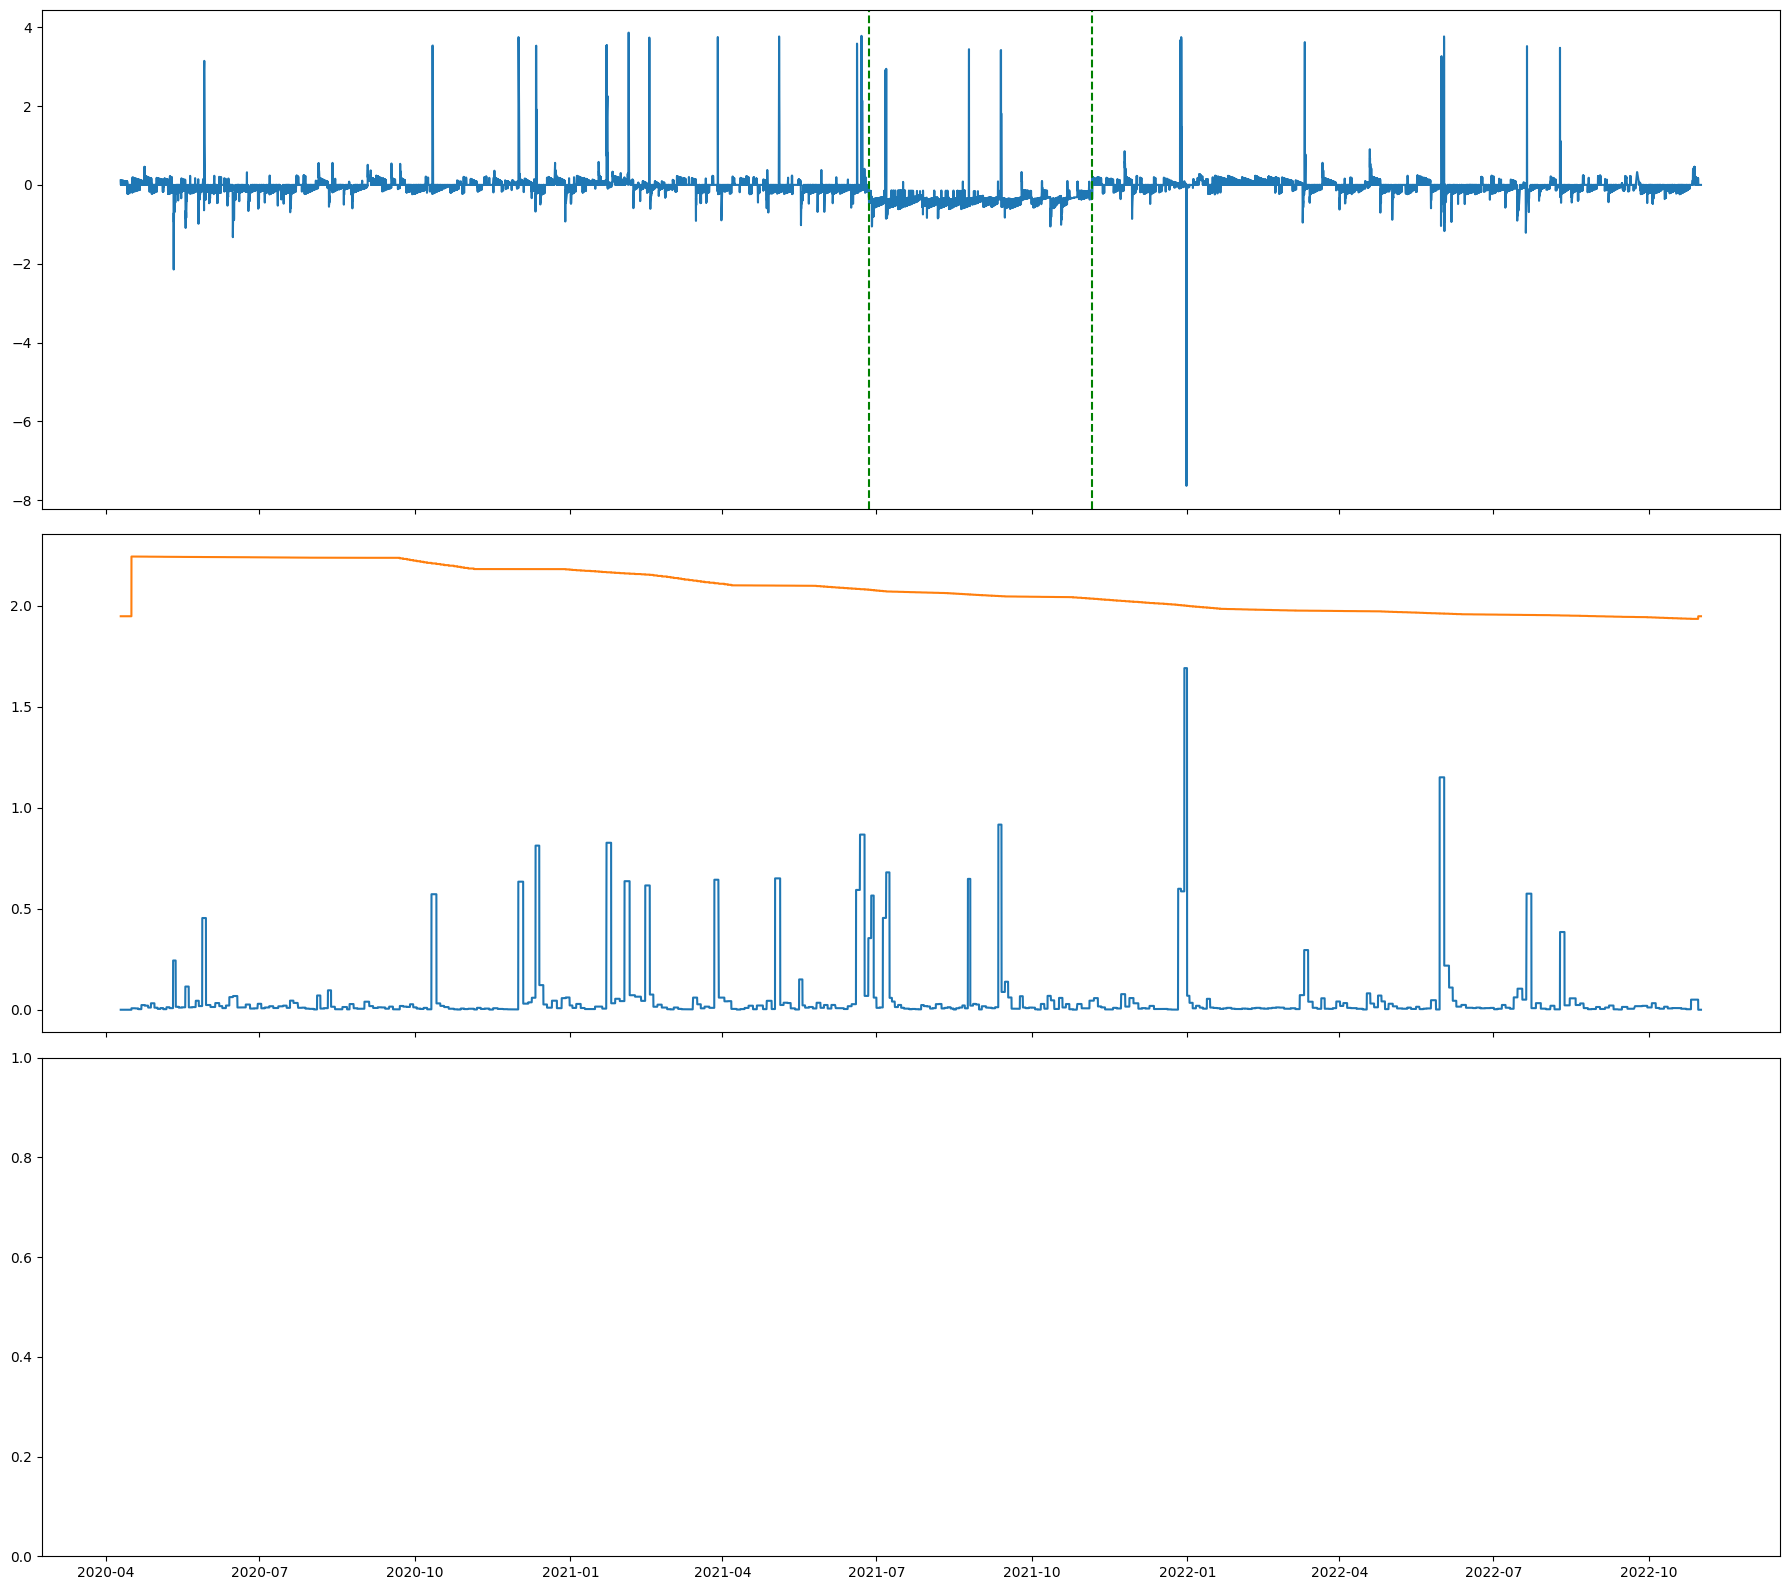

In [83]:
filtered = filtered + [0]*(len(scores) - len(filtered))
ts = pd.to_datetime(test_seq['Time'])
fig = plt.figure()
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)

ax[0].plot(ts, filtered)
ax[0].axvline(x=pd.to_datetime(test_seq.loc[startindex,'Time']), color='green', linestyle='--')
ax[0].axvline(x=pd.to_datetime(test_seq.loc[stopindex,'Time']), color='green', linestyle='--')
ax[1].plot(ts, scores)
ax[1].plot(ts, thresholds)
plt.tight_layout()
plt.show()